# ESN - Echo State Networks

ESNs are a type of recurrent neural network (RNN) designed to handle sequential data efficiently within a reservoir computing framework. 

The reservoir, which is a fixed, randomly initialized recurrent layer, forms the core of the network. 

It transforms the input data into a high-dimensional space, capturing temporal patterns through its dynamic, echo-like responses.

## Working of ESNs

- Reservoir: The ESN contains a unique component called the "reservoir," which consists of a network of interconnected neurons. These neurons collectively capture and store patterns from the input data, effectively acting as a memory of previous inputs.

- Training: During training, we expose the ESN to a subset of our data, allowing it to familiarize itself with the underlying patterns. Rather than learning everything in detail, the ESN grasps the general trends, similar to giving a few illustrative examples to someone to help them understand how to make predictions.

- Predicting: When presented with new data (such as recent temperature readings), the ESN leverages its learned patterns to forecast the next value. This process is akin to making an educated guess based on past observations.

- Output: The ESN generates its prediction, which we can then compare against the actual result. If the prediction is accurate, that's a positive outcome. If not, adjustments may be necessary to improve the model's performance.

---

## Mackey-Glass Time Series

Before jumping into ESN, lets understand out time series, if you are not interested in mathematical working, it is a chaotic time series that is often used to study non linear dynamical systems

(Skip the below part if not interested in learning about Machkey-Glass Time Series, you can move directly to ESN)

The series is given by:

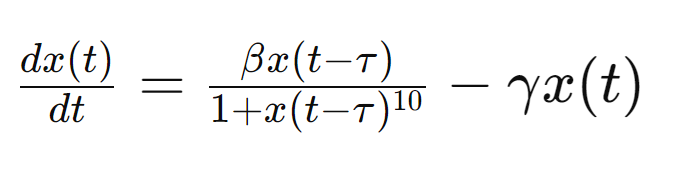 

Its key parameters are:

- β: A positive parameter that affects the feedback strength.
- 𝛾: A positive parameter representing the decay rate.
- 𝜏: A delay parameter that introduces time-delayed feedback into the system.



### Generating Mackey-Glass Time Series

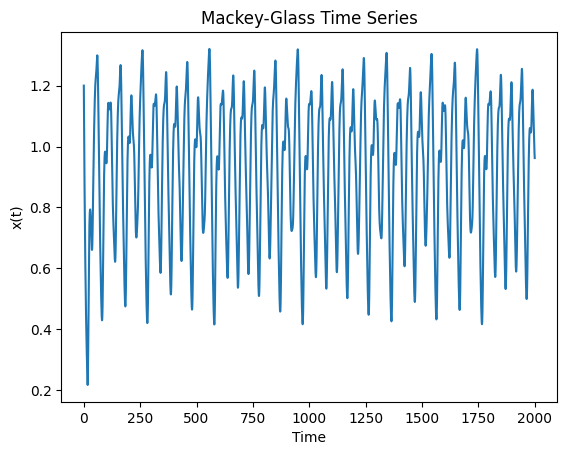

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def mackey_glass(t_max, delta_t, beta=0.2, gamma=0.1, tau=17, initial_value=1.2):
    t = np.arange(0, t_max, delta_t)
    x = np.zeros(len(t))
    x[0] = initial_value

    for i in range(1, len(t)):
        if i - int(tau / delta_t) > 0:
            x_tau = x[i - int(tau / delta_t)]
        else:
            x_tau = 0
        x[i] = x[i - 1] + delta_t * (beta * x_tau / (1 + x_tau**10) - gamma * x[i - 1])

    return t, x

# Generate the data
t, x = mackey_glass(t_max=2000, delta_t=0.1)
plt.plot(t, x)
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Time Series')
plt.show()


---

## ESN using tensorflow

In [31]:
### Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

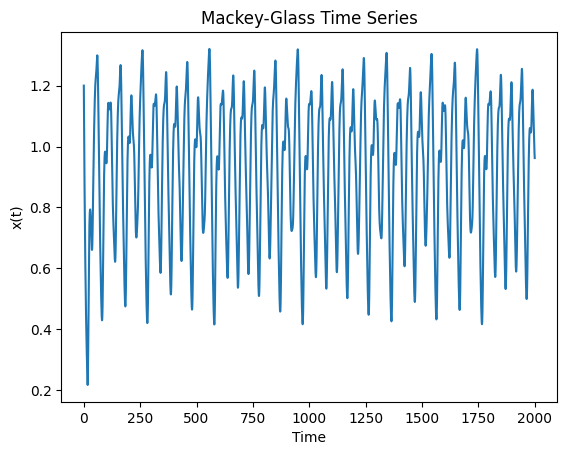

In [32]:
# Generate the data
t, x = mackey_glass(t_max=2000, delta_t=0.1) #Function created in the previous cell
plt.plot(t, x)
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Time Series')
plt.show()

In [33]:
# Prepare data
input_data = x[:-1].reshape(-1, 1)
output_data = x[1:].reshape(-1, 1)

# Split into training and testing datasets
train_size = int(len(input_data) * 0.8)
U_train, U_test = input_data[:train_size], input_data[train_size:]
y_train, y_test = output_data[:train_size], output_data[train_size:]

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

class ESNLayer(layers.Layer):
    def __init__(self, units, spectral_radius=0.95, sparsity=0.1, **kwargs):
        super(ESNLayer, self).__init__(**kwargs)
        self.units = units  # Number of neurons in the reservoir
        self.spectral_radius = spectral_radius  # Control for the echo state property
        self.sparsity = sparsity  # Proportion of non-zero connections in the reservoir
        self.state_size = self.units  # Size of the RNN state

    def build(self, input_shape):
        # Initialize input-to-reservoir weight matrix with random values
        self.W_in = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='random_normal',
            trainable=True  # These weights will be trained
        )

        # Create and initialize the reservoir weight matrix with sparsity
        W = np.random.rand(self.units, self.units) - 0.5
        W[np.random.rand(*W.shape) > self.sparsity] = 0  # Apply sparsity
        eigenvalues = np.max(np.abs(np.linalg.eigvals(W)))  # Compute the largest eigenvalue
        # Scale the weight matrix to control the spectral radius
        self.W = self.add_weight(
            shape=(self.units, self.units),
            initializer=tf.constant_initializer(W * (self.spectral_radius / eigenvalues)),
            trainable=False  # These weights remain fixed after initialization
        )
        self.built = True

    def call(self, inputs, states):
        prev_state = states[0]  # Previous state of the reservoir
        # Update the state using a tanh activation function
        state = tf.nn.tanh(tf.matmul(inputs, self.W_in) + tf.matmul(prev_state, self.W))
        return state, [state]  # Return the new state

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        # Initialize the state of the reservoir to zeros
        return [tf.zeros((batch_size, self.units))]

# Function to create and compile the ESN model
def create_esn_model(input_shape, n_reservoir, spectral_radius=0.95, sparsity=0.1):
    # Define the input layer
    inputs = layers.Input(shape=input_shape)
    # Add the custom ESN layer
    esn_layer = ESNLayer(n_reservoir, spectral_radius=spectral_radius, sparsity=sparsity)
    # Use RNN wrapper to apply the ESN layer
    rnn = layers.RNN(esn_layer, return_sequences=True)(inputs)
    # Add a Dense layer to map the reservoir states to the output
    outputs = layers.Dense(1)(rnn)
    # Create the model
    model = models.Model(inputs, outputs)
    # Compile the model with Adam optimizer and mean squared error loss
    model.compile(optimizer='adam', loss='mse')
    return model

# Example usage:
# Define the input shape and reservoir parameters
input_shape = (None, 1)
n_reservoir = 500
spectral_radius = 0.9
sparsity = 0.1

# Create and compile the ESN model
esn_model = create_esn_model(input_shape, n_reservoir, spectral_radius, sparsity)

# The model is now ready to be trained and used for predictions


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.9091
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.7637
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.6314
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.5118
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.4047
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.3100
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.2277
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 0.1580
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 0.1010
Epoch 10/10
1/1 [==============================] - 0s 471ms/step


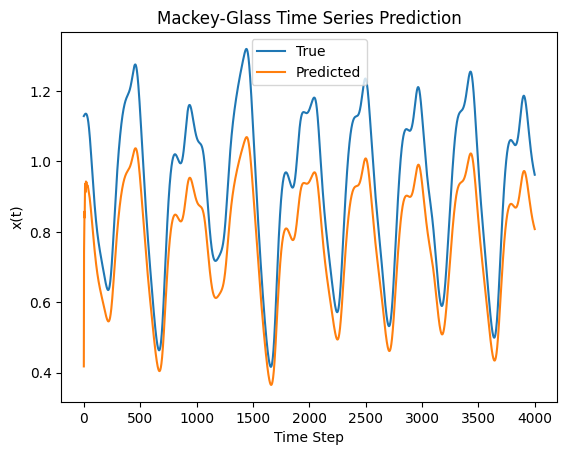

In [35]:
# Prepare data for Keras
U_train_keras = U_train.reshape((1, U_train.shape[0], U_train.shape[1]))
y_train_keras = y_train.reshape((1, y_train.shape[0], y_train.shape[1]))
U_test_keras = U_test.reshape((1, U_test.shape[0], U_test.shape[1]))
y_test_keras = y_test.reshape((1, y_test.shape[0], y_test.shape[1]))

# Create and train the model
esn_model = create_esn_model(input_shape=(None, 1), n_reservoir=500, spectral_radius=0.9, sparsity=0.1)
esn_model.fit(U_train_keras, y_train_keras, epochs=10)

# Make predictions
y_pred_keras = esn_model.predict(U_test_keras).flatten()

# Plot results
plt.plot(y_test, label='True')
plt.plot(y_pred_keras, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Time Series Prediction')
plt.legend()
plt.show()


---

## ESN using RCN library

In [36]:
!pip install PyRCN


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


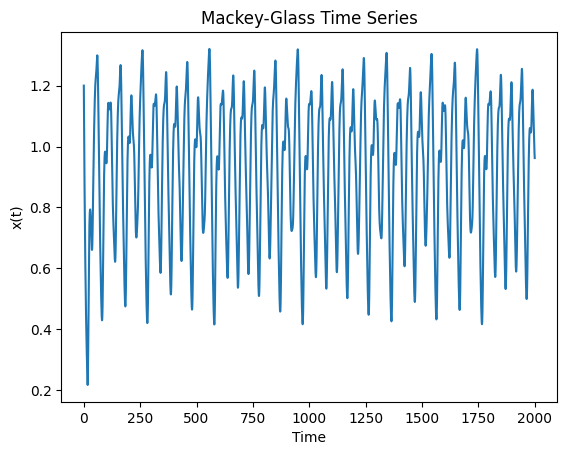

In [37]:
# Generate the data
t, x = mackey_glass(t_max=2000, delta_t=0.1)
plt.plot(t, x)
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Time Series')
plt.show()

In [38]:
# Prepare data
input_data = x[:-1].reshape(-1, 1)
output_data = x[1:].reshape(-1, 1)

# Split into training and testing datasets
train_size = int(len(input_data) * 0.8)
U_train, U_test = input_data[:train_size], input_data[train_size:]
y_train, y_test = output_data[:train_size], output_data[train_size:]

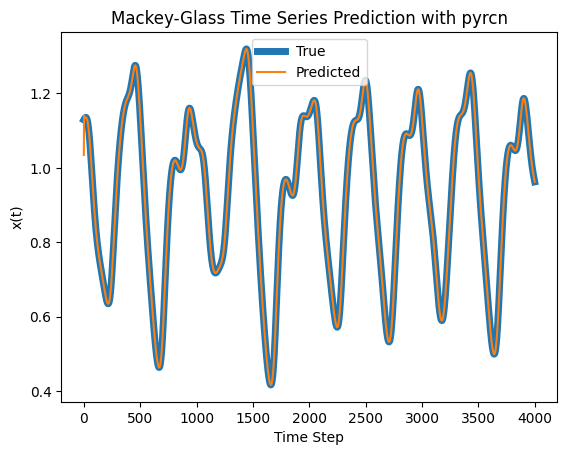

In [39]:
from pyrcn.echo_state_network import ESNRegressor

# Initialize ESN
esn = ESNRegressor(n_reservoir=500, spectral_radius=0.9, sparsity=0.1, noise=0.0001)
# - n_reservoir: Number of neurons in the reservoir, which captures temporal patterns in the data.
# - spectral_radius: Scale of the reservoir's recurrent weights, influencing network dynamics.
# - sparsity: Proportion of non-zero connections in the reservoir, promoting simpler dynamics.
# - noise: Amount of random noise added to the reservoir's dynamics, aiding in regularization.

# Train ESN
esn.fit(U_train, y_train)

# Make predictions
y_pred = esn.predict(U_test)

# Plot results
#I want that the true labels have a thicker line than the predicted labels

plt.plot(y_test, label='True', linewidth=5.0)   #Thicker line to differentiate 
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Time Series Prediction with pyrcn')
plt.legend()
plt.show()
